In [13]:
!pip install matplotlib scikit-learn tqdm

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import sys
!{sys.executable} -m pip install librosa



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\shiva\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [3]:
# Grammar Scoring Engine - Code Implementation

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm import tqdm


In [7]:

# Define paths
TRAIN_AUDIO_DIR = r"C:\Users\shiva\Downloads\shl_ast\Dataset\audios\train"
TEST_AUDIO_DIR = r"C:\Users\shiva\Downloads\shl_ast\Dataset\audios\test"
TRAIN_CSV = r"C:\Users\shiva\Downloads\shl_ast\Dataset\train.csv"
TEST_CSV = r"C:\Users\shiva\Downloads\shl_ast\Dataset\test.csv"
SUBMISSION_CSV = r"C:\Users\shiva\Downloads\shl_ast\Dataset\sample_submission.csv"
OUTPUT_SUBMISSION = 'submission.csv'



In [8]:

# Feature extraction function
def extract_features(file_path, duration=60, sr=16000):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

        features = np.hstack([
            mfcc.mean(axis=1), mfcc.std(axis=1),
            chroma.mean(axis=1), chroma.std(axis=1),
            zcr.mean(), zcr.std(),
            spectral_centroid.mean(), spectral_centroid.std()
        ])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(54)


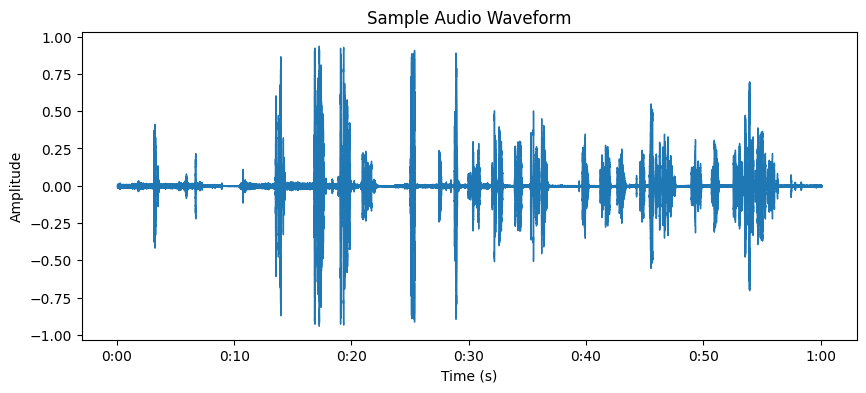

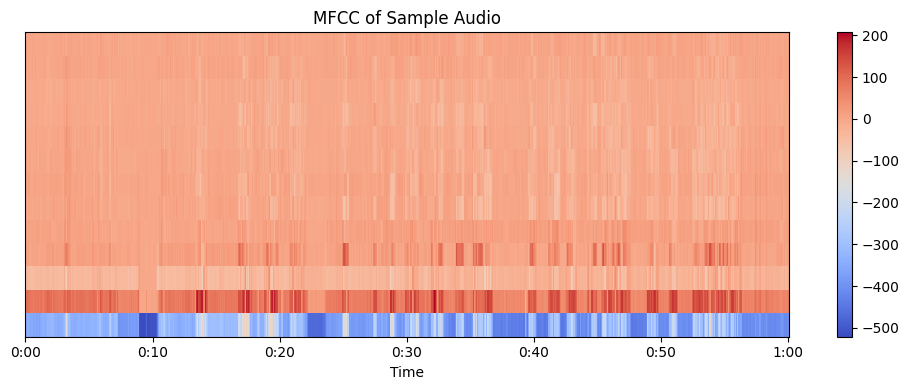

In [9]:

# Load training data
train_df = pd.read_csv(TRAIN_CSV)
X = []
y = train_df['label'].values

# Visualize a sample waveform and MFCC
sample_file = os.path.join(TRAIN_AUDIO_DIR, train_df['filename'].iloc[0])
y_audio, sr_audio = librosa.load(sample_file, sr=16000)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_audio, sr=sr_audio)
plt.title('Sample Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

mfcc_sample = librosa.feature.mfcc(y=y_audio, sr=sr_audio, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_sample, x_axis='time', sr=sr_audio)
plt.colorbar()
plt.title('MFCC of Sample Audio')
plt.tight_layout()
plt.show()


In [10]:

# Extract training features
print("Extracting training features...")
for fname in tqdm(train_df['filename']):
    path = os.path.join(TRAIN_AUDIO_DIR, fname)
    features = extract_features(path)
    X.append(features)

X = np.array(X)

# Split training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Validate model
y_pred = model.predict(X_val)
print("Validation MAE:", mean_absolute_error(y_val, y_pred))
print("Validation R2 Score:", r2_score(y_val, y_pred))


Extracting training features...


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [05:00<00:00,  1.48it/s]


Validation MAE: 0.714691011235955
Validation R2 Score: 0.4356286566172356


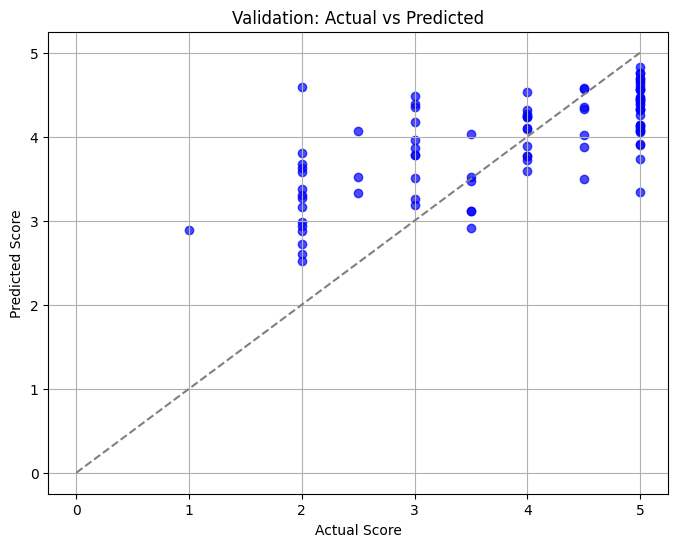

Extracting test features...


100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [02:16<00:00,  1.49it/s]

Submission saved as: submission.csv


In [11]:

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.7, color='blue')
plt.plot([0, 5], [0, 5], '--', color='gray')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Validation: Actual vs Predicted')
plt.grid(True)
plt.show()

# Load test data
test_df = pd.read_csv(TEST_CSV)
X_test = []

# Extract test features
print("Extracting test features...")
for fname in tqdm(test_df['filename']):
    path = os.path.join(TEST_AUDIO_DIR, fname)
    features = extract_features(path)
    X_test.append(features)

X_test = np.array(X_test)

# Make predictions
test_preds = model.predict(X_test)
test_preds = np.round(test_preds, 1)

# Create submission file
submission_df = pd.read_csv(SUBMISSION_CSV)
submission_df['label'] = test_preds
submission_df.to_csv(OUTPUT_SUBMISSION, index=False)
print("Submission saved as:", OUTPUT_SUBMISSION)